<h1>Step 1: EDA</h1>

`Importing all the necessary libraries and packages`

In [51]:
import numpy as np
import pandas as pd
import os
import glob as gb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras import layers, callbacks
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.optimizers import RMSprop
from keras.applications import VGG16

`Defining all the directory paths`

In [16]:
train_path = "C://Abhinav//Test//DL//fruits//train"
test_path = "C://Abhinav//Test//DL//fruits//test"
pred_path = "C://Abhinav//Test//DL//fruits//predict"

`This step saves us a lot of time. We are printing the number of files in each class. This will show us if all the classes are balanced or not.`

`Edit(after running the cell): As we can see, all the given 10 classes have an equal number of images, of course there is one class with (+1) image, but that's not going to overfit our model.`

In [17]:
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path) + "/" + folder + "/*.jpeg")
    print(f"For training data, found {len(files)} images in folder {folder}")

For training data, found 230 images in folder Apple
For training data, found 230 images in folder avocado
For training data, found 230 images in folder Banana
For training data, found 230 images in folder cherry
For training data, found 230 images in folder kiwi
For training data, found 231 images in folder mango
For training data, found 230 images in folder orange
For training data, found 230 images in folder pinenapple
For training data, found 230 images in folder strawberries
For training data, found 230 images in folder watermelon


`Now, we move onto the testing directory. We are printing the number of images in the testing directory also. But we won't be modifying the testing directory or the images within at all.`

`Edit(After running the cell): We can see that even the testing classes are pretty much balanced, give or take (+5 or -5).`

In [18]:
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path) + "/" + folder + "/*.jpeg")
    print(f"For testing data, found {len(files)} images in folder {folder}")

For testing data, found 89 images in folder apple
For testing data, found 105 images in folder avocado
For testing data, found 106 images in folder banana
For testing data, found 105 images in folder cherry
For testing data, found 105 images in folder kiwi
For testing data, found 105 images in folder mango
For testing data, found 97 images in folder orange
For testing data, found 105 images in folder pinenapple
For testing data, found 103 images in folder stawberries
For testing data, found 105 images in folder watermelon


`We will now check how may files we have in our prediction directory.`

`Edit(After running the cell): We can see that we have 48 files in the predict directory. We don't have the predcition directory split into classes, because "we have to predict them and segregate them into classes".`

In [19]:
files = gb.glob(pathname=str(pred_path) + "/*.jpeg")
print("Total Number of files for prediction:", len(files))

Total Number of files for prediction: 48


In [20]:
classes = sorted(os.listdir(train_path))
print("The classes are as follows- ", ", ".join([f"{i}:{c}" for i,c in enumerate(classes)]))

The classes are as follows-  0:Apple, 1:Banana, 2:avocado, 3:cherry, 4:kiwi, 5:mango, 6:orange, 7:pinenapple, 8:strawberries, 9:watermelon


<h1>Step 2: Data Augmentation</h1>

`We don't need to augment any images as such for this dataset as our training directory is perfectly balanced. And as for testing directory, we don't do any augmentation on testing data, so we are going to leave it as it is. The only augmentation that we are doing is some basic operations like rotating images, shearing, etc. to extract as many features as possible.`

In [21]:
TRAINING_DIR = train_path
TESTING_DIR = test_path

train_datagen = ImageDataGenerator(
    rotation_range=15, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    rescale=1./255, 
    validation_split=0.2)

test_datagen = ImageDataGenerator(
    rotation_range=15, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    rescale=1./255
)

training_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    classes=classes,
    color_mode='rgb',
    batch_size = 64,
    target_size=(256, 256),
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    classes=classes,
    color_mode="rgb",
    batch_size = 64,
    target_size = (256, 256),
    class_mode="categorical",
    subset="validation"
)

testing_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    classes=list(map(lambda x:x.lower().replace("strawberries","strawberries"),classes)),
    color_mode="rgb",
    batch_size = 64,
    target_size = (256, 256),
    class_mode = "categorical"
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 922 images belonging to 10 classes.


<h1>Step 2: Custom CNN Architecture</h1>

`My custom CNN arcithecture consists of a number of fine-tuned features. I used some in-built functions to augment the data at the input layers, even after the main augmentation has been done. We have 3 Convolution layers, and 4 Dense layers. We used BatchNormalization and we use high dropout as mentioned in the comments.`

In [29]:
#------------------------------------------------
# Add Custom CNN model
#------------------------------------------------
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    # A good dose of augmentation so that training data is hard to memorize,
    # but not too much to make the learning difficult.
    layers.RandomRotation(0.1, input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomFlip(),
    layers.GaussianNoise(0.03),
    
    # Convolution Layers
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4),
    layers.Flatten(),
    
    # dense portion of with high dropout rate for high regularization
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# add callbacks for early stopping and LR reduction during training
callback_list = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8, onitor="val_accuracy", patience=3)
]

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_5 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_5 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 gaussian_noise_5 (Gaussian  (None, 256, 256, 3)       0         
 Noise)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_16 (Ba  (None, 254, 254, 32)     

In [30]:
history = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=5, verbose=1,
                    callbacks=callback_list)

Epoch 1/5


29/29 [==============================] - 78s 2s/step - loss: 2.7237 - accuracy: 0.1309 - val_loss: 2.2982 - val_accuracy: 0.1000 - lr: 0.0050
Epoch 2/5
29/29 [==============================] - 53s 2s/step - loss: 2.2429 - accuracy: 0.1510 - val_loss: 2.3201 - val_accuracy: 0.1000 - lr: 0.0050
Epoch 3/5
29/29 [==============================] - 48s 2s/step - loss: 2.1212 - accuracy: 0.1776 - val_loss: 2.3526 - val_accuracy: 0.1022 - lr: 0.0050
Epoch 4/5
29/29 [==============================] - 48s 2s/step - loss: 1.9801 - accuracy: 0.1955 - val_loss: 2.5360 - val_accuracy: 0.1000 - lr: 0.0050
Epoch 5/5
29/29 [==============================] - 48s 2s/step - loss: 1.9178 - accuracy: 0.2287 - val_loss: 2.5029 - val_accuracy: 0.1391 - lr: 0.0040


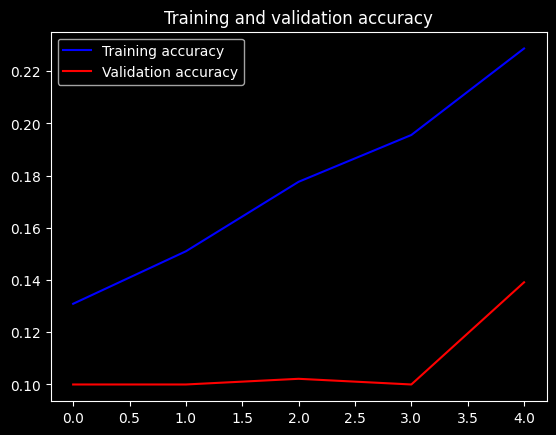

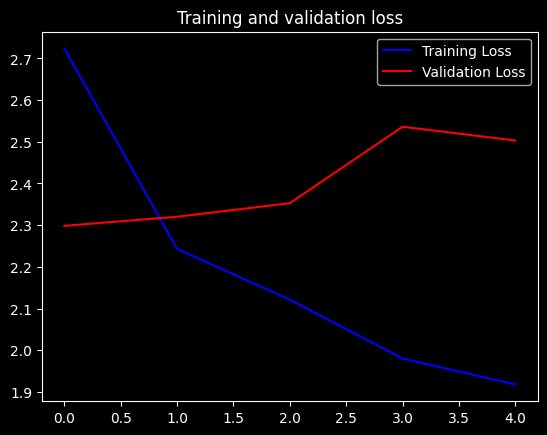

In [52]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
# plt.figure("dark")
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Desired output. Charts with training and validation metrics. No crash :)

In [38]:
model.evaluate(testing_generator)

15/15 [==============================] - 21s 1s/step - loss: 2.4588 - accuracy: 0.1584


[2.4587912559509277, 0.15835140645503998]

In [39]:
model.evaluate(validation_generator)

8/8 [==============================] - 9s 1s/step - loss: 2.5067 - accuracy: 0.1413


[2.5066604614257812, 0.14130434393882751]

<h1>Step 3: VGG-16</h1>

`We are performing Transfer Learning using VGG16. VGG16 is a pre-trained model consisting of 16 layers in total. We modify the architecutre by freezing certain layers and also by adding a custom output architecture.`

In [44]:
from keras.applications import VGG16
#------------------------------------------------
# Add VGG16 model
#------------------------------------------------
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers in VGG19
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])

vgg16_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

vgg16_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_40 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 64)               

In [47]:
# Train the VGG16 model
history_vgg16 = vgg16_model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=2,
    verbose=1,
    callbacks=callback_list
)

Epoch 1/2
29/29 [==============================] - 457s 15s/step - loss: 2.3030 - accuracy: 0.1108 - val_loss: 2.2908 - val_accuracy: 0.1717 - lr: 0.0010
Epoch 2/2
29/29 [==============================] - 390s 13s/step - loss: 2.2861 - accuracy: 0.1439 - val_loss: 2.2741 - val_accuracy: 0.1652 - lr: 0.0010


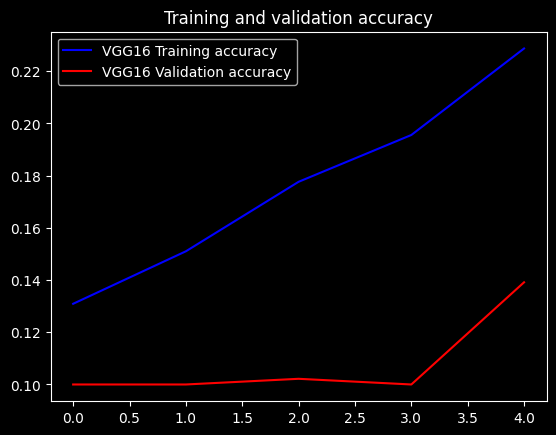

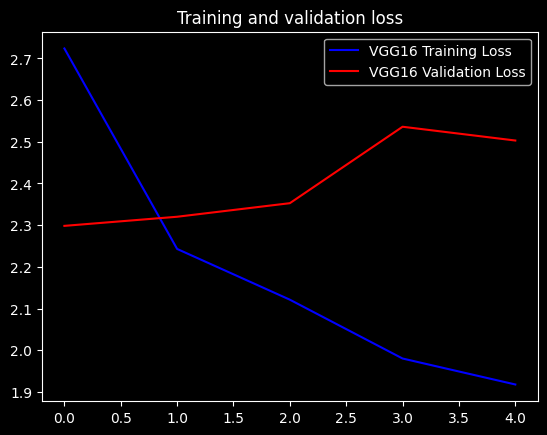

In [53]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_vgg16=history.history['accuracy']
val_acc_vgg16=history.history['val_accuracy']
loss_vgg16=history.history['loss']
val_loss_vgg16=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.plot(epochs, acc_vgg16, 'b', label='VGG16 Training accuracy')
plt.plot(epochs, val_acc_vgg16, 'r', label='VGG16 Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss_vgg16, 'b', label='VGG16 Training Loss')
plt.plot(epochs, val_loss_vgg16, 'r', label='VGG16 Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Desired output. Charts with training and validation metrics. No crash :)

In [56]:
vgg16_model.evaluate(testing_generator)

15/15 [==============================] - 147s 9s/step - loss: 2.2783 - accuracy: 0.1703


[2.278325319290161, 0.17028199136257172]